In [1]:
"""
Jax implentation of the tempered bootstrap particle filter
"""

import jax.numpy as jnp
import jax.random as jr
from jax import Array, vmap, lax, jit
import jax

from resample.resamplers import RESAMPLERS
from feynmac_kac.utils import log_normalize, ess
from feynmac_kac.protocol import FeynmacKac, PFConfig, PFOutputs, CSMC

from jax.scipy.stats import multivariate_normal

from dynamax.linear_gaussian_ssm import lgssm_filter, lgssm_smoother
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from model.lgssm import LGSSMModel
from utils.datasets import load_dataset

from feynmac_kac.bootstrap import BootstrapParticleFilter


In [2]:
def find_temper_delta(log_w_norm, log_g_t, beta, ess_target):
    left, right = 1e-3, 1.0 - beta

    def ess_at(delta):
        lw_new = log_w_norm + delta * log_g_t
        lw_new -= jax.nn.logsumexp(lw_new)
        return ess(jnp.exp(lw_new)), lw_new

    def bisect(_):
        def cond(carry):
            l, r = carry
            return (r - l) > 1e-4

        def body(carry):
            l, r = carry
            mid = 0.5 * (l + r)
            ess_mid, _ = ess_at(mid)
            # ESS decreases with delta
            l = jnp.where(ess_mid > ess_target, mid, l)   # ESS too high → increase Δβ
            r = jnp.where(ess_mid <= ess_target, mid, r)  # ESS too low → shrink Δβ
            return (l, r)

        l, r = jax.lax.while_loop(cond, body, (left, right))
        return 0.5 * (l + r)

    ess_left, _ = ess_at(left)
    ess_right, _ = ess_at(right)

    # jax.debug.print("[ESS] left={}, right={}", ess_left, ess_right)

    # handle edge cases based on monotonic ESS
    delta = jax.lax.cond(
        ess_target >= ess_left,      # target ESS higher than achievable (Δβ=0)
        lambda _: left,
        lambda _: jax.lax.cond(
            ess_target <= ess_right,  # target ESS too low (Δβ=max)
            lambda _: right,
            lambda _: bisect(_),
            operand=None
        ),
        operand=None
    )

    ess_val, lw_new = ess_at(delta)
    return delta, ess_val, lw_new


In [3]:
class TemperedBPF:
    """
    The Bootstrap PF takes the potential function as the emission likelihood,
    and the Markov transition kernel as the proposal distribution. Unlike a guided PF,
    the Bootstrap PF cannot use lookahead information from the observations when proposing particles.
    """

    def __init__(self, model: FeynmacKac, config: PFConfig):
        self.model = model
        self.cfg = config
        self.key = config.key
        self.resampler = RESAMPLERS[config.resample_scheme]

        self.vmapped_pt = vmap(lambda key, x, t: self.model.pt(key, x, t), in_axes=(0, 0, None))
        self.vmapped_log_g = vmap(self.model.log_g, in_axes=(None, 0, 0, None))
        self.vmapped_log_pt = vmap(self.model.log_pt, in_axes=(None, 0, 0))
        
    def filter(self, key: jr.PRNGKey, T: int, obs: Array) -> PFOutputs:
        """
        """

        N = self.cfg.N
        ess_min = self.cfg.ess_threshold * N if self.cfg.ess_threshold is not None else jnp.inf    

        # t = 0 
        key0, key = jr.split(key)
        x_n0, log_wn0, norm_w_n0, logZ_0 = self.t0(key0, N, obs[0])

        def step(carry, obs_t):
            
            key, x_n_prev, log_wn_prev, norm_wn_prev, logZ_prev = carry
            key1, key2 = jr.split(key)
            t, y_t = obs_t

            # jax.debug.print("[step] t={}", t)

            # sample transition
            keys_t = jr.split(key1, N)
            x_nt = self.vmapped_pt(keys_t, x_n_prev, t)  # (N,d)
            
            # tempering (does resampling and weight calculation)
            key_temper, x_nt, log_wnt, idx = self.temper(
                key2,           # RNG
                x_nt,           # current particles
                x_n_prev,       # previous particles
                t,              # time index
                y_t,            # observation
                ess_min,        # ESS threshold
                N,              # number of particles
            )
            
            w_nt_norm, logZ_t = log_normalize(log_wnt)
            logZ = logZ_prev + logZ_t
            
            # track ESS and resampling index (dummy idx here, since temper handles resampling internally)
            ess_t = ess(w_nt_norm)
            
            return (key_temper, x_nt, log_wnt, w_nt_norm, logZ), (
                x_nt,
                w_nt_norm,
                idx,
                ess_t,
            )
        
        obs = (jnp.arange(1, T), obs[1:])
        carry0 = (key, x_n0, log_wn0, norm_w_n0, logZ_0)
        (key, _, _, w_nT_norm, logZ_hat), (particles, weights, ancestors, ess_hist) = lax.scan(step, carry0, obs)

        # prepend t=0
        particles = jnp.concatenate([x_n0[None, ...], particles], axis=0)               # (T+1, N, d)
        weights = jnp.concatenate([norm_w_n0[None, ...], weights], axis=0)              # (T+1, N)
        ess_hist = jnp.concatenate([ess_hist, jnp.array([ess(w_nT_norm)])], axis=0)     # (T+1,)

        self.key = key

        return PFOutputs(
            particles=particles,
            weights=weights,
            ancestors=ancestors,
            logZ_hat=logZ_hat,
            ess_history=ess_hist,
        )
    
    def t0(self, key: jr.PRNGKey, N, obs0: Array):
        x_n0 = self.model.p0(key, N)  # (N,d)
        log_wn0 = self.vmapped_log_g(0, x_n0, jnp.zeros_like(x_n0), obs0)  # (N,)
        norm_w_n0, logZ_0 = log_normalize(log_wn0)
        return x_n0, log_wn0, norm_w_n0, logZ_0
    
    def resample(self, key, N, norm_wn_prev, ess_min, x_n_prev, log_wn_prev):
        def do_resample(_):
            # jax.debug.print("[Resampling]: ess={}", ess_t)
            idx = self.resampler(key, norm_wn_prev)
            return x_n_prev[idx], jnp.zeros(N), idx
        
        def skip_resample(_):
            return x_n_prev, log_wn_prev, jnp.arange(N)
        
        ess_t = ess(norm_wn_prev)
        x_n_prev, log_wn_prev, idx = lax.cond(
            ess_t < ess_min,
            do_resample,
            skip_resample,
            operand=None
        )
        return x_n_prev, log_wn_prev, idx, ess_t
    
    def temper(self, key, x_nt, x_n_prev, t, y_t, ess_min, N):
        """
        
        1. Sample x_nt_b as x_nt_b | x_nb_prev ~ N(A @ x_nb_prev, Q / b). If b=0 use x_n_prev.
        2. Calculate tempered log potentials (beta @ log_g_curr) using x_nt_b and y_t. 
        3. If ESS < ESS_min: resample.
        4. Repeat until b = 1

        TODOs:
         - correct the doc string above
         - correct the lineage tracking through MCMC mutations and resampling.
        """

        beta = 0.0
        x_nt_b = x_nt

        # start with weights 1/N
        norm_wb = jnp.ones(N) / N
        log_wb = jnp.log(norm_wb) 
        log_g_curr = self.vmapped_log_g(t, x_nt_b, x_n_prev, y_t)
        log_pt_curr = self.vmapped_log_pt(t, x_nt_b, x_n_prev)
        
        def cond(carry):
            beta, *_ = carry
            return beta < 1.0 - 1e-5

        def step(carry):
            
            beta, key, x_nt_b, log_wb_prev, log_g_curr, log_pt_curr, _ = carry

            # 1. Find delta temperature
            delta, _, _ = find_temper_delta(log_wb_prev, log_g_curr, beta, ess_min)
            delta = jnp.minimum(delta, 1.0 - beta)
            beta = beta + delta

            # jax.debug.print("[temperature] beta={}", beta)

            # 2. Compute new weights
            # log_g_curr = self.vmapped_log_g(t, x_nt_b, x_n_prev, y_t)
            # log_pt_curr = self.vmapped_log_pt(t, x_nt_b, x_n_prev)
            log_wb = log_wb_prev + (delta * log_g_curr)
            norm_wb, _ = log_normalize(log_wb)

            # 3. Potentially resample
            key, subkey = jr.split(key)
            x_nb_res, log_wb, idx, ess_tb = self.resample(
                subkey, N, norm_wb, ess_min, x_nt_b, log_wb
            )
            log_g_curr = log_g_curr[idx]
            log_pt_curr = log_pt_curr[idx]

            # 4. Gaussian local proposal
            key, key_norm, key_unif = jr.split(key, 3)
            noise = 0.1 * jr.normal(key_norm, shape=x_nb_res.shape)
            x_nt_b_prop = x_nb_res + noise

            # 5. Calculate acceptances for proposals
            log_g_prop = self.vmapped_log_g(t, x_nt_b_prop, x_n_prev, y_t)
            log_pt_prop = self.vmapped_log_pt(t, x_nt_b_prop, x_n_prev)

            unif_n = jr.uniform(key_unif, shape=(x_nt_b.shape[0], ))
            logA = beta * (log_g_prop - log_g_curr) + (log_pt_prop - log_pt_curr)
            alpha = jnp.minimum(1.0, jnp.exp(logA))
            accept = unif_n <= alpha

            # update x and log potentials to reflect acceptances
            x_nb_next  = jnp.where(accept[:, None], x_nt_b_prop, x_nb_res)
            log_g_next  = jnp.where(accept, log_g_prop, log_g_curr)
            log_pt_next  = jnp.where(accept, log_pt_prop, log_pt_curr)
                
            # # reset weights
            # norm_wb = jnp.ones(N) / N
            # log_wb = jnp.log(norm_wb)
            
            return (beta, key, x_nb_next, log_wb, log_g_next, log_pt_next, idx)

        # run the temper scan
        beta, key, x_nt, log_wb, _, _, idx = jax.lax.while_loop(
            cond,
            step,
            (beta, key, x_nt_b, log_wb, log_g_curr, log_pt_curr, jnp.arange(N))
        )
        return key, x_nt, log_wb, idx


## LGSSM Example

In [4]:
def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_smoother(params, y)
    print("Exact filter means shape: ", lgssm_posterior.smoothed_means.shape)
    return lgssm_posterior


def bpf(key, data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(data.params)
    
    # construct bootstrap particle filter
    bpf = BootstrapParticleFilter(
        model=lgssm,
        config=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key,
        T=data.train_data[0].shape[1],
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs

def tempered_bpf(key, data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(data.params)
    
    # construct bootstrap particle filter
    bpf = TemperedBPF(
        model=lgssm,
        config=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.3,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key,
        T=data.train_data[0].shape[1],
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs



In [5]:
data = load_dataset('linear_large', seed=0)
data = data.standardized_data
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 30)


In [6]:
outs = tempered_bpf(jr.PRNGKey(10), data, 5000)
outs.particles.shape, outs.weights.shape

BPF particles shape:  (300, 5000, 30)
BPF weights shape:  (300, 5000)
BPF logZ_hat:  -2506.0571


((300, 5000, 30), (300, 5000))

Tempered BPF weighted x_t shape:  (300, 30)
MSE from BPF to exact filter means:  0.06909191


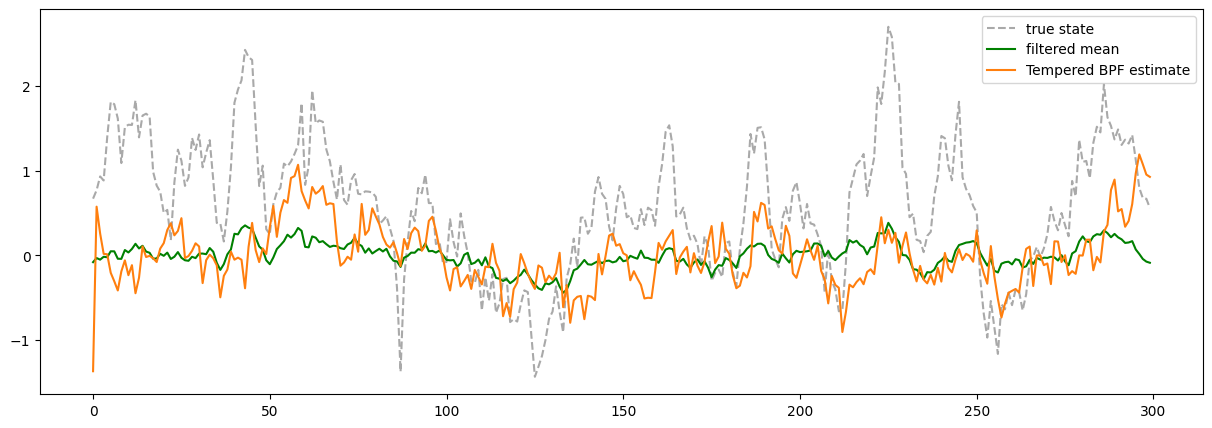

In [7]:
# calculate weighted estimates of state means
x_hat = jnp.sum(outs.weights[:, :, None] * outs.particles, axis=1)
print("Tempered BPF weighted x_t shape: ", x_hat.shape)

# calculate MSE against true filter means
mse = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
print("MSE from BPF to exact filter means: ", mse)

# plot results
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
# ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
ax.plot(x_hat[:, 3], color="tab:orange", label="Tempered BPF estimate")
plt.legend()
plt.show()

N: 50000                                                                                               
BPF particles shape:  (300, 50000, 30)
BPF weights shape:  (300, 50000)
BPF logZ_hat:  -17187.262
BPF particles shape:  (300, 50000, 30)
BPF weights shape:  (300, 50000)
BPF logZ_hat:  -2287.6372
Tempered BPF weighted x_t shape:  (300, 30)

MSE from Regular BPF to exact filter means:  0.09234249
MSE from Tempered BPF to exact filter means:  0.048754655 




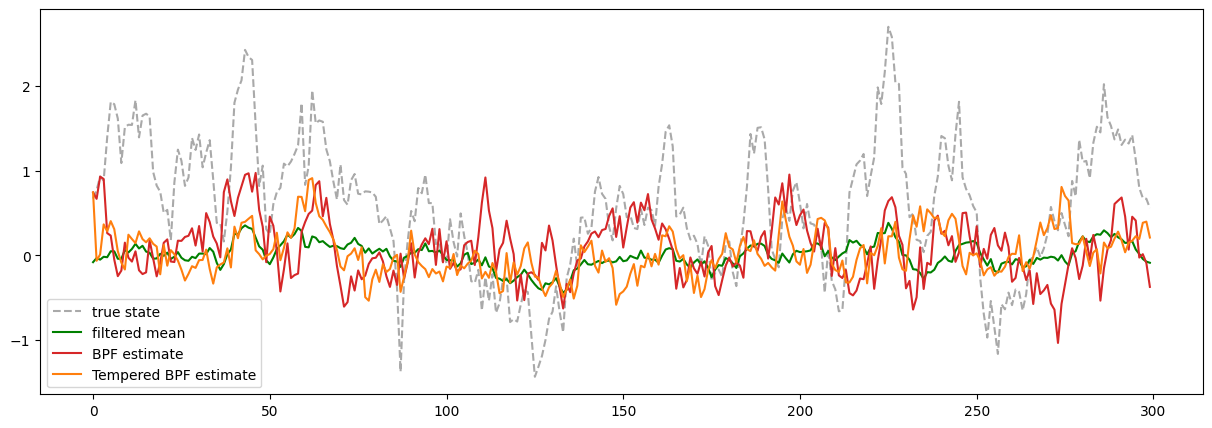

In [8]:
for N in [50000]:
    print(f"N: {N:<-100}")
    bpf_outs = bpf(jr.PRNGKey(N), data, N)
    tmp_outs = tempered_bpf(jr.PRNGKey(N), data, N)
    
    # calculate weighted estimates of state means
    bpf_x_hat = jnp.sum(bpf_outs.weights[:, :, None] * bpf_outs.particles, axis=1)
    tmp_x_hat = jnp.sum(tmp_outs.weights[:, :, None] * tmp_outs.particles, axis=1)
    print("Tempered BPF weighted x_t shape: ", tmp_x_hat.shape)
    
    # calculate MSE against true filter means
    bpf_mse = jnp.mean((bpf_x_hat - lgssm_posterior.filtered_means)**2)
    tmp_mse = jnp.mean((tmp_x_hat - lgssm_posterior.filtered_means)**2)
    print("\nMSE from Regular BPF to exact filter means: ", bpf_mse, )
    print("MSE from Tempered BPF to exact filter means: ", tmp_mse, "\n\n")
    
    # plot results
    observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
    ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
    # ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
    ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
    ax.plot(bpf_x_hat[:, 3], color="tab:red", label="BPF estimate")
    ax.plot(tmp_x_hat[:, 3], color="tab:orange", label="Tempered BPF estimate")
    plt.legend()
    plt.show()
    print("\n\n")